In [111]:
import torch
import pretrained_microscopy_models as pmm
import torch.utils.model_zoo as model_zoo

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os 
import random
from towbintools.foundation import image_handling
from towbintools.foundation import binary_image
import cv2
from scipy.ndimage import binary_fill_holes
from time import perf_counter

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import time
from skimage import io
from skimage.transform import resize
import xgboost as xgb

from csbdeep.utils import normalize
import cv2
from towbintools.foundation import image_handling
from towbintools.foundation import binary_image
from time import perf_counter
from scipy.ndimage import binary_fill_holes
import random
from joblib import Parallel, delayed

import torch
import torch.nn as nn
from torchvision.models import vgg16
import torchvision
import torch.nn.functional as F

In [112]:
def init_VGG16_micronet():

    model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16_bn', weights=None)
    url = pmm.util.get_pretrained_microscopynet_url('vgg16_bn', 'image-micronet')

    # remove classifier from model 
    model.classifier = nn.Sequential(*list(model.classifier.children())[:-8])
    # Load pretrained weights

    model.load_state_dict(model_zoo.load_url(url, map_location=torch.device('cpu')))

    model.eval()  # <- MicrosNet model for classifcation or transfer learning

    # Extract up to 'block1_conv2'
    features_seq = list(model.features)[:2]
    new_model = nn.Sequential(*features_seq)

    # Disable gradient computation (use pretrained weights)
    for param in new_model.parameters():
        param.requires_grad = False
    
    return new_model

def fd_VGG16_scaled_pytorch(img, model, shape, device):
    '''Scale the image to the appropriate input scale,
       feed into VGG16 filters. Scale filter responses to 
       match original image size.
    '''
    
    # Ensure the image tensor is a PyTorch tensor
    if not isinstance(img, torch.Tensor):
        img = torch.tensor(img).float()
    
    # Move image to the same device as the model
    img = img.to(device)

    # Resize image to new shape
    img_scaled = F.interpolate(img.unsqueeze(0), size=shape, mode='bilinear', align_corners=True)

    # Predict class in PyTorch for each pixel
    with torch.no_grad():
        features = model(img_scaled)

    # Remove extra dimensions and resize to match original image size
    fv_VGG16 = F.interpolate(features, size=(img.shape[1], img.shape[2]), mode='bilinear', align_corners=True)
    
    # Convert back to numpy if desired (optional)
    fv_VGG16 = fv_VGG16.squeeze(0)

    return fv_VGG16

def fd_VGG16_pyramid_pytorch(img,model,shapes, device):
    '''Loop over all input scales
        img: input image to calculate vgg response of
        models: list of all vgg16 models 
        shapes: corresponding shapes
    '''    
    fv_list = []
    for shape in shapes:
        fv = fd_VGG16_scaled_pytorch(img,model,shape, device)
        fv_list.append(fv)
    global_feature = torch.concatenate(fv_list,axis=0)
    global_feature = torch.transpose(global_feature, 0, 2)
    global_feature = torch.transpose(global_feature, 0, 1)
    return global_feature

def grayscale_to_rgb_pytorch(grayscale_img):
    img = np.expand_dims(grayscale_img, axis=0)
    stacked_img = np.stack((img,)*3, axis=0)
    stacked_img = np.squeeze(stacked_img)
    return stacked_img

def extract_features_pytorch(img, model, shapes, device):
    img = normalize(img,1,99.8,axis=(0,1))
    img = image_handling.normalize_image(img, np.uint8)
    img = grayscale_to_rgb_pytorch(img)

    features = fd_VGG16_pyramid_pytorch(img,model,shapes, device)
    return features

In [113]:
model = init_VGG16_micronet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

image_dir = "/mnt/external.data/TowbinLab/kstojanovski/20220401_Ti2_20x_160-182-190_pumping_25C_20220401_173300_429/analysis/ch1/"
images = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.tiff')]
random.seed(42)
training_set = random.sample(images, 100)

shapes = []
for i in [1, 2, 4, 8]:
    shapes.append((int(2048/i),(int(2044/i))))

Using cache found in /home/spsalmon/.cache/torch/hub/pytorch_vision_v0.10.0


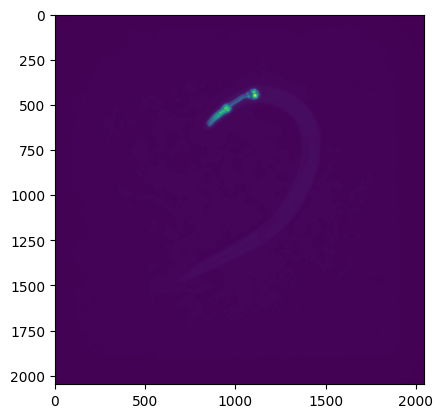

In [114]:
image = image_handling.read_tiff_file(training_set[0])
plt.imshow(image)
plt.show()

In [115]:
# image = grayscale_to_rgb_pytorch(image)
model.eval()
with torch.no_grad():
    features = extract_features_pytorch(image, model, shapes, device).cpu().numpy()
    print(features.shape)

ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [2044] and output size of (2048, 2044). Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.

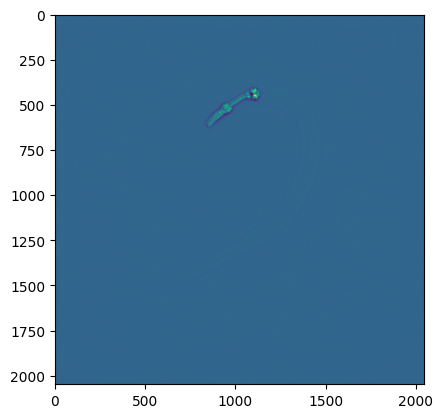

In [ ]:
plt.imshow(features[:,:,210])
plt.show()